# Курсовая работа по дисциплине "Технологии анализа данных и машинное обучение"

### Автор: Кузнецов Михаил.
### Группа: Пи19-4.
### Тема: 4. Сравнение методов регрессии на реальных наборах данных.  
 

#### Загружаем необходимые для работы модули

In [122]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter("ignore")

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

#### Чтение данных из файла bottle.csv

In [124]:
def read_data():
    df_bottle = pd.read_csv("data/bottle.csv", index_col="Btl_Cnt")
    return df_bottle

#### Выбираем из датасета только нужные нам столбцы, а именно: 
1) T_degC - Температура воды в градусах Цельсия.

2) Salnty - Соленость воды в граммах соли на киллограмм воды (г/кг).

3) Depthm - Глубина воды в метрах.

#### Переименовываем названия столбцов на более понятные названия.

In [125]:
def clean(df):
    df = df[["T_degC", "Salnty", "Depthm"]]
    df.rename(columns={
        "T_degC": "Temperature",
        "Salnty": "Salinity",
        "Depthm": "Depth"
    }, inplace=True)
    
    return df

#### Предобработка данных

In [126]:
# Можно просто удалить все значения, в которых есть пропуски через df.dropna()
# Но у нас данных и так мало. Экспериментально было установлено, что данная функция уберет примерно 10% датасета, что неприемлимо для нашей задачи
# Таким образом мы выбрали иной метод "борьбы" с пропусками - он описан в функции ниже
def impute(df):
    # для всех численных типов пустые значения заполнить по методу ffill - последнее не нулевое значение присваивается в пустые ячейки
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(method="ffill")
    # для всех категориальных типов датафрейма отсутствующие значения заполняются словом None    
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
#     df.dropna()
    return df

#### Функция для чтения, переименования и предобработки данных.
    Выдает обработанный датасет.

In [127]:
def load_data():
    df_bottle = read_data() 
    
    df_bottle = clean(df_bottle)
    
    df_bottle = impute(df_bottle)
    
    return df_bottle

# Начало основной работы.

Загружаем данные

In [128]:
df_bottle = load_data()

Показываем первые 5 строк датасета

In [129]:
df_bottle.head()

,Temperature,Salinity,Depth
Btl_Cnt,,,
1,10.50,33.440,0
2,10.46,33.440,8
3,10.46,33.437,10
4,10.45,33.420,19
5,10.45,33.421,20


Описательная статистика

In [130]:
df_bottle.describe()

,Temperature,Salinity,Depth
count,864863.000000,864863.000000,864863.000000
mean,10.791383,33.836106,226.831951
std,4.259400,0.469311,316.050259
min,1.440000,28.431000,0.000000
25%,7.660000,33.480000,46.000000
50%,10.050000,33.850000,125.000000
75%,13.890000,34.200000,300.000000
max,31.140000,37.034000,5351.000000


Попарная корреляция всех столбцов в кадре данных

In [131]:
df_bottle.corr()

,Temperature,Salinity,Depth
Temperature,1.000000,-0.451946,-0.673307
Salinity,-0.451946,1.000000,0.512194
Depth,-0.673307,0.512194,1.000000


Графическое представление данных с помощью парных графиков

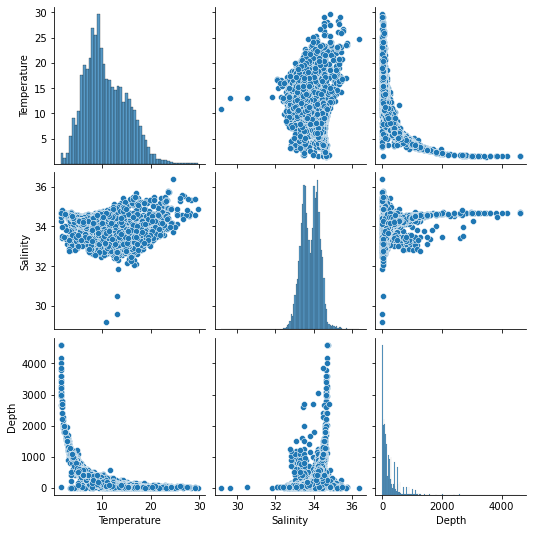

In [132]:
sns.pairplot(data=df_bottle.sample(10000))

Строим корреляционную матрицу

Text(0.5, 1.0, 'Корреляционная матрица')

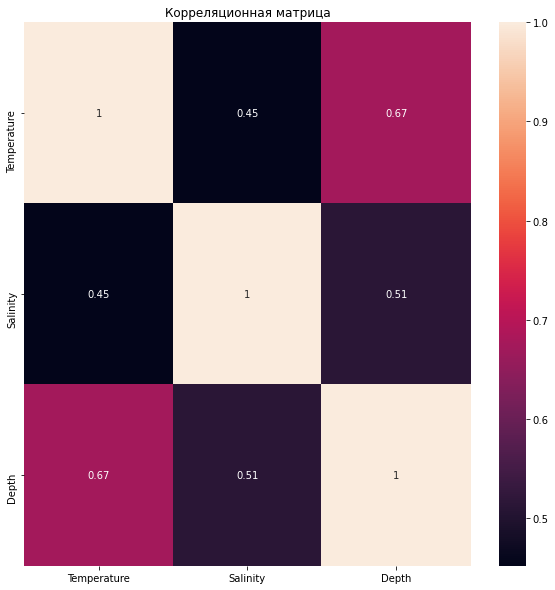

In [133]:
plt.figure(figsize=(10,10))
sns.heatmap(df_bottle.corr().abs(), annot=True)
plt.title("Корреляционная матрица")

# Вспомогательные функции

#### Функция, которая показывает оценки для прогнозируемых данных, а именно:

1)  Средняя Абсолютная Ошибка 
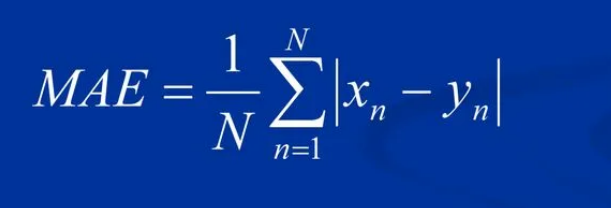

2) Средняя квадратическая ошибка
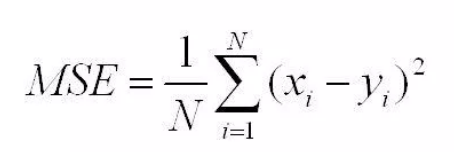

3) Коэффициент детерминации
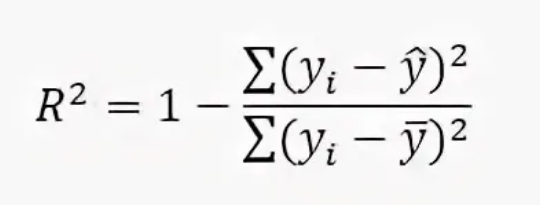

In [135]:
def evaluate(y_test, y_pred):
    print("Средняя Абсолютная Ошибка (MAE): %.2f" % np.mean(np.absolute(y_pred - y_test)))
    print("Средняя Квадратическая Ошибка (MSE): %.2f" % np.mean((y_pred - y_test) ** 2))
    print("Коэффициент детерминации (R2): %.2f" % r2_score(y_test , y_pred))

#### Функция, которая показывает коэффициенты и точку пересечения модели.

In [136]:
def coeffecients(model):
    print("Коэффициенты модели:", model.coef_)
    print("Точка пересечения: ", model.intercept_)

# Делаем предсказания на основе регрессий

#### Будем использовать разные модели регрессий, а именно

    1) Парная линейная регрессия 
    
    2) Множественная регрессия
    
    3) Полиномиальная регрессия 
    
    4) Случайный лес
    
    5) Деревья решений
    
    6) Регрессия LASSO
    
    7) Гребневая регрессия (ридж-регрессия)
    
    8) Метод k ближайших соседей

## Линейная регрессия

#### Делим наш набор данных на обучающую выборку и тестовую выборку.
#### В данном случае будем строить предсказание температуры воды по солености воды.

In [137]:
X_train, X_test, y_train, y_test = train_test_split(df_bottle[['Salinity']].values, df_bottle[["Temperature"]].values, test_size=0.2, random_state=123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691890, 1), (172973, 1), (691890, 1), (172973, 1))

#### Обучаем модель линейной регрессии по обучающей выборке
#### Предсказываем результат
##### Создаем датафрейм, состоящий из:
    1) Солености воды - Salinity
    
    2) Температура воды - Temperature (реальное значение)
    
    3) Температура воды предсказанное - Temp_pred_linear_salnity (предсказанное значение)

In [138]:
%%time
#Обучение и предсказание
regression = LinearRegression()
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

#Создаем датафрейм
result_df_salnity = pd.DataFrame(X_test, columns=["Salinity"])
result_df_salnity["Temperature"] = y_test
result_df_salnity["Temp_pred_linear_salnity"] = y_pred
result_df_salnity


Wall time: 19.9 ms


,Salinity,Temperature,Temp_pred_linear_salnity
0,33.1700,14.440,13.519074
1,34.1990,5.590,9.302588
2,34.3000,5.760,8.888725
3,34.1510,8.610,9.499275
4,34.1930,11.180,9.327174
...,...,...,...
172968,33.6242,19.579,11.657920
172969,33.6600,16.910,11.511224
172970,34.0960,6.070,9.724646
172971,33.3940,14.560,12.601200


#### График сравнения предсказанной температуры воды от реальной температуры воды.

    1) Предсказанная температура воды отмечена зеленым цветом.

    2) Реальная температура воды - синим. 

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

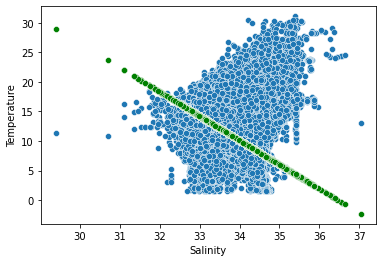

In [139]:
sns.scatterplot(data=result_df_salnity, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_salnity, x="Salinity", y="Temp_pred_linear_salnity", color='green')

Выводим оценки для прогнозируемых данных, а так же, коэффициенты и точку пересечения модели.

In [140]:
print("Коэффициент детерминации прогноза: %.2f" % regression.score(X_train, y_train))
coeffecients(regression)
evaluate(y_test, y_pred)

Коэффициент детерминации прогноза: 0.20
Коэффициенты модели: [[-4.09765436]]
Точка пересечения:  [149.43826965]
Средняя Абсолютная Ошибка (MAE): 2.82
Средняя Квадратическая Ошибка (MSE): 14.47
Коэффициент детерминации (R2): 0.21


Как видно из графика и оценок, линейная регрессия является не точной, коэффициент детерминации слишком низкий, ошибки MAE, MSE достаточно высокие, модель не эффективна.

## Множественная регрессия по соли и глубине

Делим наш набор данных на обучающую выборку и тестовую выборку.

    x_train, x_test состоит из солености воды и глубины

    y_train, y_test из реальной температуры

In [141]:
X_train, X_test, y_train, y_test = train_test_split(df_bottle[['Salinity', "Depth"]].values, df_bottle[["Temperature"]].values, test_size=0.2, random_state=34)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((691890, 2), (172973, 2), (691890, 1), (172973, 1))

Обучаем модель множественной регрессии по обучающей выборке

Предсказываем результат


In [142]:
%%time
regression = LinearRegression()
regression.fit(X_train, y_train)
y_pred = regression.predict(X_test)

Wall time: 38.9 ms


Выводим оценки для прогнозируемых данных, а так же, коэффициенты и точку пересечения модели.

In [143]:
print("Коэффициент детерминации прогноза: %.2f" % regression.score(X_train, y_train))
coeffecients(regression)
evaluate(y_test, y_pred)

Коэффициент детерминации прогноза: 0.47
Коэффициенты модели: [[-1.32483099 -0.00805667]]
Точка пересечения:  [57.44369562]
Средняя Абсолютная Ошибка (MAE): 2.33
Средняя Квадратическая Ошибка (MSE): 9.61
Коэффициент детерминации (R2): 0.47


#### Создаем датафрейм, состоящий из:
1) Солености воды - Salinity

2) Глубины воды - Depth

3) Температура воды - Temperature (реальное значение)

4) Температура воды предсказанное - Temp_pred_linear_multiple (предсказанное значение)

In [144]:
result_df_linear_multiple = pd.DataFrame(X_test, columns=["Salinity", "Depth"])
result_df_linear_multiple["Temperature"] = y_test
result_df_linear_multiple["Temp_pred_linear_multiple"] = y_pred
result_df_linear_multiple.head()

,Salinity,Depth,Temperature,Temp_pred_linear_multiple
0,34.1580,400.0,6.340,8.967452
1,33.5312,0.0,16.125,13.020523
2,33.7410,87.0,10.460,12.041643
3,33.5700,74.0,13.470,12.372926
4,33.3570,30.0,14.960,13.009608


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим. 

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

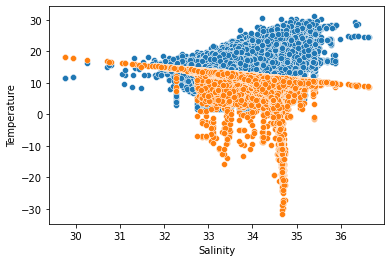

In [145]:
sns.scatterplot(data=result_df_linear_multiple, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_linear_multiple, x="Salinity",  y="Temp_pred_linear_multiple")

Как видно из графика и оценок прогнозируемых данных, прогноз по множественной регрессии оказался лучше, чем у парной линейной регрессии.



## Полиномиальная регрессия

#### Функция для ввода заданной пользователем степени полиномиальной регрессии 

В данной функции происходит обучение модели полиномиальной регрессии по обучающей выборке, а так же, предсказывание температуры.

Так же, в данной функции находятся оценки прогнозируемых данных.

In [146]:
def generatePolynomialFeatures(degree = 2):
    poly_reg = PolynomialFeatures(degree)
    
    # Преобразуем матрицу функций x в новую матрицу функций X_train_poly, X_test_poly
    X_train_poly = poly_reg.fit_transform(X_train)
    X_test_poly = poly_reg.fit_transform(X_test)
    
    # Обучение
    polynomial_regression = LinearRegression()
    polynomial_regression.fit(X_train_poly, y_train)
    
    # Предсказываем результат
    y_pred = polynomial_regression.predict(X_test_poly)
    
    #Оценки прогноза
    print("Коэффициент детерминации прогноза полиномиальной регресии: %.2f" % polynomial_regression.score(X_train_poly, y_train))
    coeffecients(polynomial_regression)
    evaluate(y_test, y_pred)
    
    return y_pred

In [147]:
%%time
y_pred = generatePolynomialFeatures()
y_pred

Коэффициент детерминации прогноза полиномиальной регресии: 0.65
Коэффициенты модели: [[ 0.00000000e+00 -1.42066021e+02 -1.10012266e-01  2.09948849e+00
   2.71282459e-03  3.82468982e-06]]
Точка пересечения:  [2416.96919386]
Средняя Абсолютная Ошибка (MAE): 1.86
Средняя Квадратическая Ошибка (MSE): 6.23
Коэффициент детерминации (R2): 0.66
Wall time: 158 ms


array([[ 7.56896155],
       [13.86679681],
       [12.11420111],
       ...,
       [12.77824895],
       [13.82674735],
       [ 8.57156355]])

### Создаем датафрейм, состоящий из:
1) Солености воды - Salinity

2) Глубины воды - Depth

3) Температура воды - Temperature (реальное значение)

4) Температура воды предсказанное - Temp_pred_polynomia_multiple (предсказанное значение)

In [148]:
result_df_polynomial_multiple = pd.DataFrame(X_test, columns=["Salinity", "Depth"])
result_df_polynomial_multiple["Temperature"] = y_test
result_df_polynomial_multiple["Temp_pred_polynomia_multiple"] = y_pred
result_df_polynomial_multiple.head()

,Salinity,Depth,Temperature,Temp_pred_polynomia_multiple
0,34.1580,400.0,6.340,7.568962
1,33.5312,0.0,16.125,13.866797
2,33.7410,87.0,10.460,12.114201
3,33.5700,74.0,13.470,12.439890
4,33.3570,30.0,14.960,13.569441


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

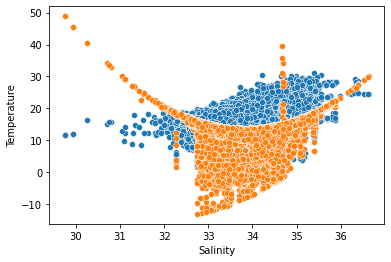

In [149]:
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple")

Как видим, результат лучше при степени полиномиальной регрессии равной 2, попробуем изменить данную степень на числа степени равные 3, 4, 5, 9.

In [150]:
%%time
y_pred3 = generatePolynomialFeatures(degree = 3)
y_pred3

Коэффициент детерминации прогноза полиномиальной регресии: 0.72
Коэффициенты модели: [[ 0.00000000e+00  1.71171084e+03  2.99128762e+00 -5.20478517e+01
  -1.84251271e-01  1.31530050e-04  5.27156619e-01  2.80869176e-03
  -3.48267901e-06 -1.66713655e-09]]
Точка пересечения:  [-18735.49534268]
Средняя Абсолютная Ошибка (MAE): 1.63
Средняя Квадратическая Ошибка (MSE): 5.01
Коэффициент детерминации (R2): 0.72
Wall time: 292 ms


array([[ 6.66105632],
       [14.74632739],
       [12.3340381 ],
       ...,
       [12.81747134],
       [14.52914824],
       [ 7.76033818]])

При изменении степени полиномиальной регрессии с 2 до 3 результат прогноза стал лучше, коэффициент детерминации прогноза увеличился, средняя квадратичная ошибка снизилась.

Запишем результат прогноза в датафрейм и построим графики для наглядности.

In [151]:
result_df_polynomial_multiple["Temp_pred_polynomia_multiple_degree3"] = y_pred3
result_df_polynomial_multiple.head()

,Salinity,Depth,Temperature,Temp_pred_polynomia_multiple,Temp_pred_polynomia_multiple_degree3
0,34.1580,400.0,6.340,7.568962,6.661056
1,33.5312,0.0,16.125,13.866797,14.746327
2,33.7410,87.0,10.460,12.114201,12.334038
3,33.5700,74.0,13.470,12.439890,12.672501
4,33.3570,30.0,14.960,13.569441,14.009593


<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

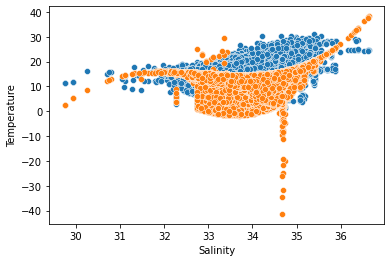

In [152]:
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple_degree3")

Теперь изменим степень полиномиальной регрессии с 3 до 4 и посмотрим на результат.

In [153]:
%%time
y_pred4 = generatePolynomialFeatures(degree = 4)
y_pred4

Коэффициент детерминации прогноза полиномиальной регресии: 0.76
Коэффициенты модели: [[ 0.00000000e+00  7.19256779e-01 -2.87807376e-01  1.53588871e+01
   1.57389059e-01 -3.35810011e-03 -6.24126108e-01 -8.97522542e-03
   2.17299693e-04 -1.70425298e-07  7.12625722e-03  1.34189130e-04
  -3.45674428e-06  4.72718633e-09  6.94964915e-13]]
Точка пересечения:  [-2755.92730042]
Средняя Абсолютная Ошибка (MAE): 1.47
Средняя Квадратическая Ошибка (MSE): 4.31
Коэффициент детерминации (R2): 0.76
Wall time: 499 ms


array([[ 6.17465019],
       [15.55833998],
       [12.37370394],
       ...,
       [12.56592198],
       [15.11644585],
       [ 7.17972499]])

Результат прогноза при степени полиномиальной регрессии равной 4 стал еще лучше, ошибки немного снизились.

Запишем результат прогноза в датафрейм и построим графики для наглядности.

In [154]:
result_df_polynomial_multiple["Temp_pred_polynomia_multiple_degree4"] = y_pred4
result_df_polynomial_multiple.head()

,Salinity,Depth,Temperature,Temp_pred_polynomia_multiple,Temp_pred_polynomia_multiple_degree3,Temp_pred_polynomia_multiple_degree4
0,34.1580,400.0,6.340,7.568962,6.661056,6.174650
1,33.5312,0.0,16.125,13.866797,14.746327,15.558340
2,33.7410,87.0,10.460,12.114201,12.334038,12.373704
3,33.5700,74.0,13.470,12.439890,12.672501,12.659572
4,33.3570,30.0,14.960,13.569441,14.009593,14.267692


<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

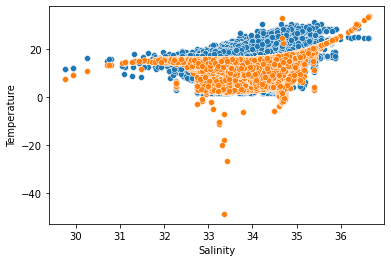

In [155]:
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple_degree4")

Теперь изменим степень полиномиальной регрессии с 4 до 5 и посмотрим на результат.

In [156]:
%%time
y_pred5 = generatePolynomialFeatures(degree = 5)
y_pred5

Коэффициент детерминации прогноза полиномиальной регресии: 0.78
Коэффициенты модели: [[ 0.00000000e+00 -4.42303288e-05  5.08407336e-05  2.49153498e-06
   8.69761169e-04 -9.50174847e-05  3.55050067e-05  9.85318068e-03
  -4.83683481e-04  4.61436113e-06 -2.26707952e-04 -5.97248219e-04
   2.97235434e-05 -2.91229822e-07  1.14548805e-10  5.55885988e-06
   8.98485953e-06 -4.51832467e-07  4.54696266e-09 -3.19069289e-12
  -3.27167893e-16]]
Точка пересечения:  [65.56977219]
Средняя Абсолютная Ошибка (MAE): 1.41
Средняя Квадратическая Ошибка (MSE): 4.03
Коэффициент детерминации (R2): 0.78
Wall time: 724 ms


array([[ 6.0500607 ],
       [15.9485971 ],
       [12.341605  ],
       ...,
       [12.42841827],
       [15.34234915],
       [ 6.92811966]])

Результат прогноза стал немного лучше.

Ошибки MAE, MSE чуть-чуть снизились, коэффициент детерминации немного повысился, что говорит нам о том, что полиномиальная регрессия степени равной 5 пока что самая точная.

Запишем результат прогноза в датафрейм и построим графики

In [157]:
result_df_polynomial_multiple["Temp_pred_polynomia_multiple_degree5"] = y_pred5
result_df_polynomial_multiple.head()

,Salinity,Depth,Temperature,Temp_pred_polynomia_multiple,Temp_pred_polynomia_multiple_degree3,Temp_pred_polynomia_multiple_degree4,Temp_pred_polynomia_multiple_degree5
0,34.1580,400.0,6.340,7.568962,6.661056,6.174650,6.050061
1,33.5312,0.0,16.125,13.866797,14.746327,15.558340,15.948597
2,33.7410,87.0,10.460,12.114201,12.334038,12.373704,12.341605
3,33.5700,74.0,13.470,12.439890,12.672501,12.659572,12.607923
4,33.3570,30.0,14.960,13.569441,14.009593,14.267692,14.317709


<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

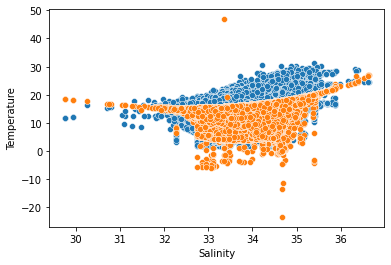

In [158]:
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple_degree5")

Теперь изменим степень полиномиальной регрессии с 5 до 9 и посмотрим на результат.

In [159]:
%%time
y_pred9 = generatePolynomialFeatures(degree = 9)
y_pred9

Коэффициент детерминации прогноза полиномиальной регресии: 0.47
Коэффициенты модели: [[-1.42190210e-20  3.99467165e-18  4.00499368e-20 -5.58664583e-22
  -1.36890805e-22 -1.02957053e-22 -1.58527405e-22 -9.92183626e-23
  -4.29959249e-20 -1.00875367e-21 -3.24243504e-20 -1.36236023e-19
   1.46801909e-19 -1.14004358e-19 -3.19831753e-20 -6.42348561e-27
  -7.97308487e-25 -1.00642690e-23 -7.95065164e-23 -8.91419675e-23
  -8.91944542e-22 -2.60679018e-25 -2.73290014e-23 -3.43240710e-22
  -2.67797361e-21 -2.15144800e-21 -1.85057114e-20 -2.82576873e-19
  -1.02857528e-23 -9.36737532e-22 -1.17068788e-20 -9.02151973e-20
  -4.49404261e-20 -3.26419468e-19 -3.07439831e-18  3.29837747e-20
  -3.97593979e-22 -3.21076724e-20 -3.99308006e-19 -3.03961932e-18
  -6.24141325e-19 -4.01886564e-18  3.14056120e-19 -3.36272422e-21
   5.00145288e-24 -1.51297607e-20 -1.10051618e-18 -1.36206644e-17
  -1.02428533e-16  7.70285449e-18 -1.13678386e-19 -2.98374323e-21
   4.05935044e-23 -2.13843661e-26 -2.10316943e-28]]
Точка

array([[ 8.47647828],
       [12.56936164],
       [12.48225735],
       ...,
       [12.51954753],
       [12.56914103],
       [10.04866921]])

Модель переобучилась, результат прогноза ухудшился, ошибки повысились, коэффициент детерминации понизился.

Запишем результат прогноза в датафрейм и построим график для наглядности.

In [160]:
result_df_polynomial_multiple["Temp_pred_polynomia_multiple_degree9"] = y_pred9
result_df_polynomial_multiple.head()

,Salinity,Depth,Temperature,Temp_pred_polynomia_multiple,Temp_pred_polynomia_multiple_degree3,Temp_pred_polynomia_multiple_degree4,Temp_pred_polynomia_multiple_degree5,Temp_pred_polynomia_multiple_degree9
0,34.1580,400.0,6.340,7.568962,6.661056,6.174650,6.050061,8.476478
1,33.5312,0.0,16.125,13.866797,14.746327,15.558340,15.948597,12.569362
2,33.7410,87.0,10.460,12.114201,12.334038,12.373704,12.341605,12.482257
3,33.5700,74.0,13.470,12.439890,12.672501,12.659572,12.607923,12.515373
4,33.3570,30.0,14.960,13.569441,14.009593,14.267692,14.317709,12.565184


<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

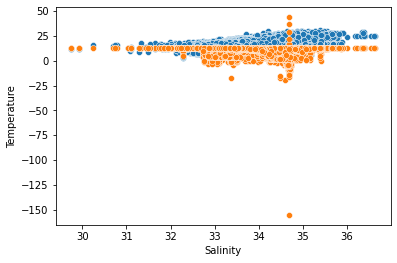

In [161]:
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple_degree9")

Построим общий график предсказанной температуры воды у разных степеней полиномиальной регрессии от реальной температуры воды.

<AxesSubplot:title={'center':'График сравнения предсказаний'}, xlabel='Salinity', ylabel='Temperature'>

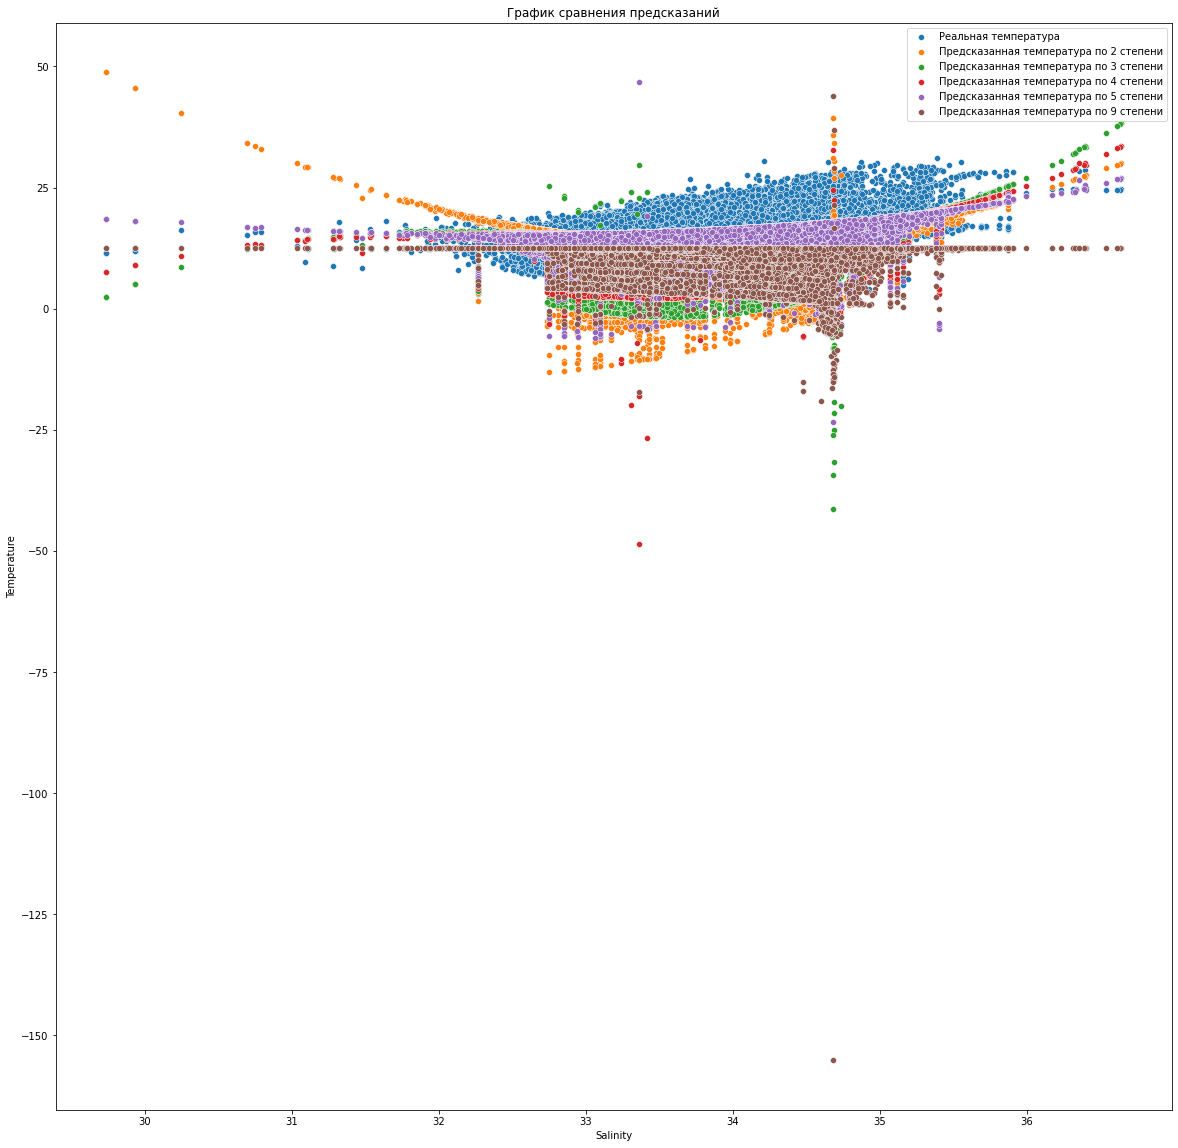

In [162]:
plt.figure(figsize=(20,20))
plt.title("График сравнения предсказаний")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temperature", label = "Реальная температура")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple", label= "Предсказанная температура по 2 степени")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple_degree3", label = "Предсказанная температура по 3 степени")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple_degree4", label = "Предсказанная температура по 4 степени")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple_degree5", label = "Предсказанная температура по 5 степени")
sns.scatterplot(data=result_df_polynomial_multiple, x="Salinity", y="Temp_pred_polynomia_multiple_degree9", label = "Предсказанная температура по 9 степени")

### Вывод: самый точный прогноз по полиномиальной регрессии был в модели, у которой степень полиномиальной регрессии равна 5.

# Случайный лес

Функция для ввода заданного пользователем количества деревьев в случайном лесу.

В данной функции происходит обучение модели случайного леса по обучающей выборке, а так же, предсказывание температуры.

Так же, в данной функции находятся оценки прогнозируемых данных.

In [163]:
def generateRandomForestRegressor(n_estimators = 10):
    rf_reg = RandomForestRegressor(n_estimators,random_state=42)
    
    #обучение модели
    rf_reg.fit(X_train, y_train)
    
    #Предсказание температуры
    y_pred_forest = rf_reg.predict(X_test)
    
    #Оценки прогноза
    print("Коэффициент детерминации прогноза случайного леса: %.2f" % rf_reg.score(X_train, y_train))
    print('Средняя Абсолютная ошибка (Mean Absolute Error):', metrics.mean_absolute_error(y_test, y_pred_forest))
    print('Средняя Квадратичная Ошибка (Mean Squared Error):', metrics.mean_squared_error(y_test, y_pred_forest))
    print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_forest))
    return y_pred_forest

In [164]:
%%time
y_pred_forest = generateRandomForestRegressor()
y_pred_forest

Коэффициент детерминации прогноза случайного леса: 0.87
Средняя Абсолютная ошибка (Mean Absolute Error): 1.2036526517285333
Средняя Квадратичная Ошибка (Mean Squared Error): 3.574496826659118
Коэффициент детерминации:  0.8028953118927993
Wall time: 12.3 s


array([ 6.43994865, 18.4104    , 11.0660381 , ..., 11.71245238,
       16.9718    ,  7.02074416])

#### Создаем датафрейм, состоящий из:
1) Солености воды - Salinity

2) Глубины воды - Depth

3) Температура воды - Temperature (реальное значение)

4) Температура воды предсказанное - Temp_pred_forest (предсказанное значение)

In [165]:
result_df_forest = pd.DataFrame(X_test, columns=["Salinity", "Depth"])
result_df_forest["Temperature"] = y_test
result_df_forest["Temp_pred_forest"] = y_pred_forest
result_df_forest.head()

,Salinity,Depth,Temperature,Temp_pred_forest
0,34.1580,400.0,6.340,6.439949
1,33.5312,0.0,16.125,18.410400
2,33.7410,87.0,10.460,11.066038
3,33.5700,74.0,13.470,12.062073
4,33.3570,30.0,14.960,14.209651


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

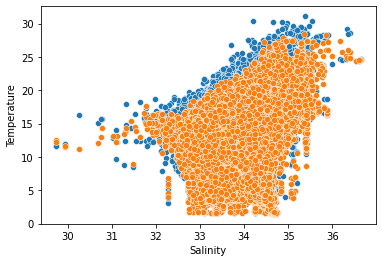

In [166]:
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temp_pred_forest")

#### Как видим, пока что данная модель достаточно хорошая и наш прогноз достаточно точен (сравнение с результатами полиномиальной регрессии): 
1) Средняя Абсолютная ошибка (MAE) понизилась.

2) Коэффициент детерминации (R2) значительно повысился.

3) Средняя квадратическая ошибка (Mean Squared Error) стала меньше.

#### Попробуем изменить количество деревьев и посмотреть, будет ли результат от этого лучше

#### Случайный лес из 20 деревьев

In [167]:
%%time
y_pred_forest20 = generateRandomForestRegressor(n_estimators = 20)
y_pred_forest20

Коэффициент детерминации прогноза случайного леса: 0.87
Средняя Абсолютная ошибка (Mean Absolute Error): 1.1982788282953993
Средняя Квадратичная Ошибка (Mean Squared Error): 3.540948471401099
Коэффициент детерминации:  0.8047452332720334
Wall time: 24.5 s


array([ 6.43258279, 18.45612262, 10.98350476, ..., 11.79220813,
       17.6087    ,  7.03462429])

#### Увеличение количества деревьев на 10, немного улучшило модель, но незначительно.

    1) Коэффициент детерминации совсем чуть-чуть повысился: с 0.8028953118927993 до 0.8047452332720334

    2) Средняя Абсолютная ошибка немного уменьшилась: c 1.2036526517285333 до 1.1982788282953993

    3) Средняя квадратичная ошибка немного уменьшилась: c 3.574496826659118 до 3.540948471401099

#### Запишем в датафрейм результат прогноза, а так же, построим графики.

In [168]:
result_df_forest["Temp_pred_forest_20"] = y_pred_forest20
result_df_forest.head()

,Salinity,Depth,Temperature,Temp_pred_forest,Temp_pred_forest_20
0,34.1580,400.0,6.340,6.439949,6.432583
1,33.5312,0.0,16.125,18.410400,18.456123
2,33.7410,87.0,10.460,11.066038,10.983505
3,33.5700,74.0,13.470,12.062073,12.215863
4,33.3570,30.0,14.960,14.209651,14.138452


<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

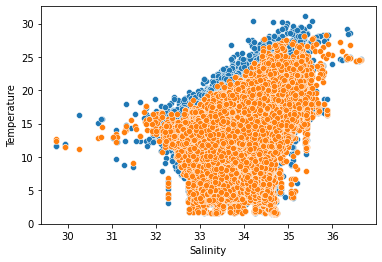

In [169]:
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temp_pred_forest_20")

#### Случайный лес из 50 деревьев

In [170]:
%%time
y_pred_forest50 = generateRandomForestRegressor(n_estimators = 50)
y_pred_forest50

Коэффициент детерминации прогноза случайного леса: 0.87
Средняя Абсолютная ошибка (Mean Absolute Error): 1.1944174753007093
Средняя Квадратичная Ошибка (Mean Squared Error): 3.5200048272420785
Коэффициент детерминации:  0.8059001064332023
Wall time: 59.7 s


array([ 6.42691058, 18.79330071, 11.10777635, ..., 12.0325419 ,
       17.48971345,  7.04878142])

#### Увеличение количества деревьев до 50, немного улучшило модель, но  незначительно.
1) Коэффициент детерминации совсем чуть-чуть повысился: с 0.8047452332720334 до 0.8059001064332023

2) Средняя Абсолютная ошибка немного уменьшилась: c 1.1982788282953993 до 1.1944174753007093

3) Средняя квадратичная ошибка немного уменьшилась: c 3.540948471401099 до 3.5200048272420785
#### Запишем в датафрейм результат прогноза, а так же, построим графики.

In [171]:
result_df_forest["Temp_pred_forest_50"] = y_pred_forest50
result_df_forest.head()

,Salinity,Depth,Temperature,Temp_pred_forest,Temp_pred_forest_20,Temp_pred_forest_50
0,34.1580,400.0,6.340,6.439949,6.432583,6.426911
1,33.5312,0.0,16.125,18.410400,18.456123,18.793301
2,33.7410,87.0,10.460,11.066038,10.983505,11.107776
3,33.5700,74.0,13.470,12.062073,12.215863,12.190423
4,33.3570,30.0,14.960,14.209651,14.138452,14.138876


<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

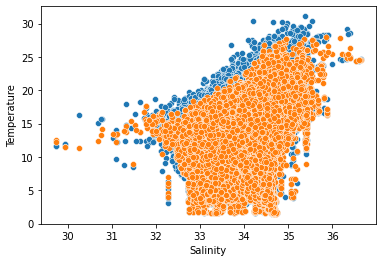

In [172]:
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temp_pred_forest_50")

#### Случайный лес из 200 деревьев

In [173]:
%%time
y_pred_forest200 = generateRandomForestRegressor(n_estimators = 200)
y_pred_forest200

Коэффициент детерминации прогноза случайного леса: 0.87
Средняя Абсолютная ошибка (Mean Absolute Error): 1.1927620967898527
Средняя Квадратичная Ошибка (Mean Squared Error): 3.508589445510995
Коэффициент детерминации:  0.8065295727231004
Wall time: 4min 3s


array([ 6.4188678 , 18.61968172, 11.16083955, ..., 11.98255164,
       17.26841657,  7.00006955])

#### Увеличение количества деревьев до 200, немного улучшило модель, но незначительно.
1) Коэффициент детерминации совсем чуть-чуть повысился: с 0.8047452332720334 до 0.8059001064332023

2) Средняя Абсолютная ошибка немного уменьшилась: c 1.1982788282953993 до 1.1944174753007093

3) Средняя квадратичная ошибка немного уменьшилась: c 3.540948471401099 до 3.5200048272420785

#### Запишем в датафрейм результат прогноза, а так же, построим графики.

In [174]:
result_df_forest["Temp_pred_forest_200"] = y_pred_forest200
result_df_forest.head()

,Salinity,Depth,Temperature,Temp_pred_forest,Temp_pred_forest_20,Temp_pred_forest_50,Temp_pred_forest_200
0,34.1580,400.0,6.340,6.439949,6.432583,6.426911,6.418868
1,33.5312,0.0,16.125,18.410400,18.456123,18.793301,18.619682
2,33.7410,87.0,10.460,11.066038,10.983505,11.107776,11.160840
3,33.5700,74.0,13.470,12.062073,12.215863,12.190423,12.204293
4,33.3570,30.0,14.960,14.209651,14.138452,14.138876,14.278802


<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

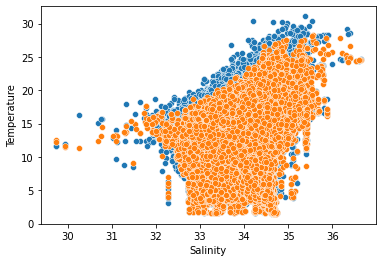

In [175]:
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temp_pred_forest_200")

Построим общий график предсказанной температуры воды у разного количества деревьев леса решений от реальной температуры воды.

<AxesSubplot:title={'center':'График сравнения предсказаний'}, xlabel='Salinity', ylabel='Temperature'>

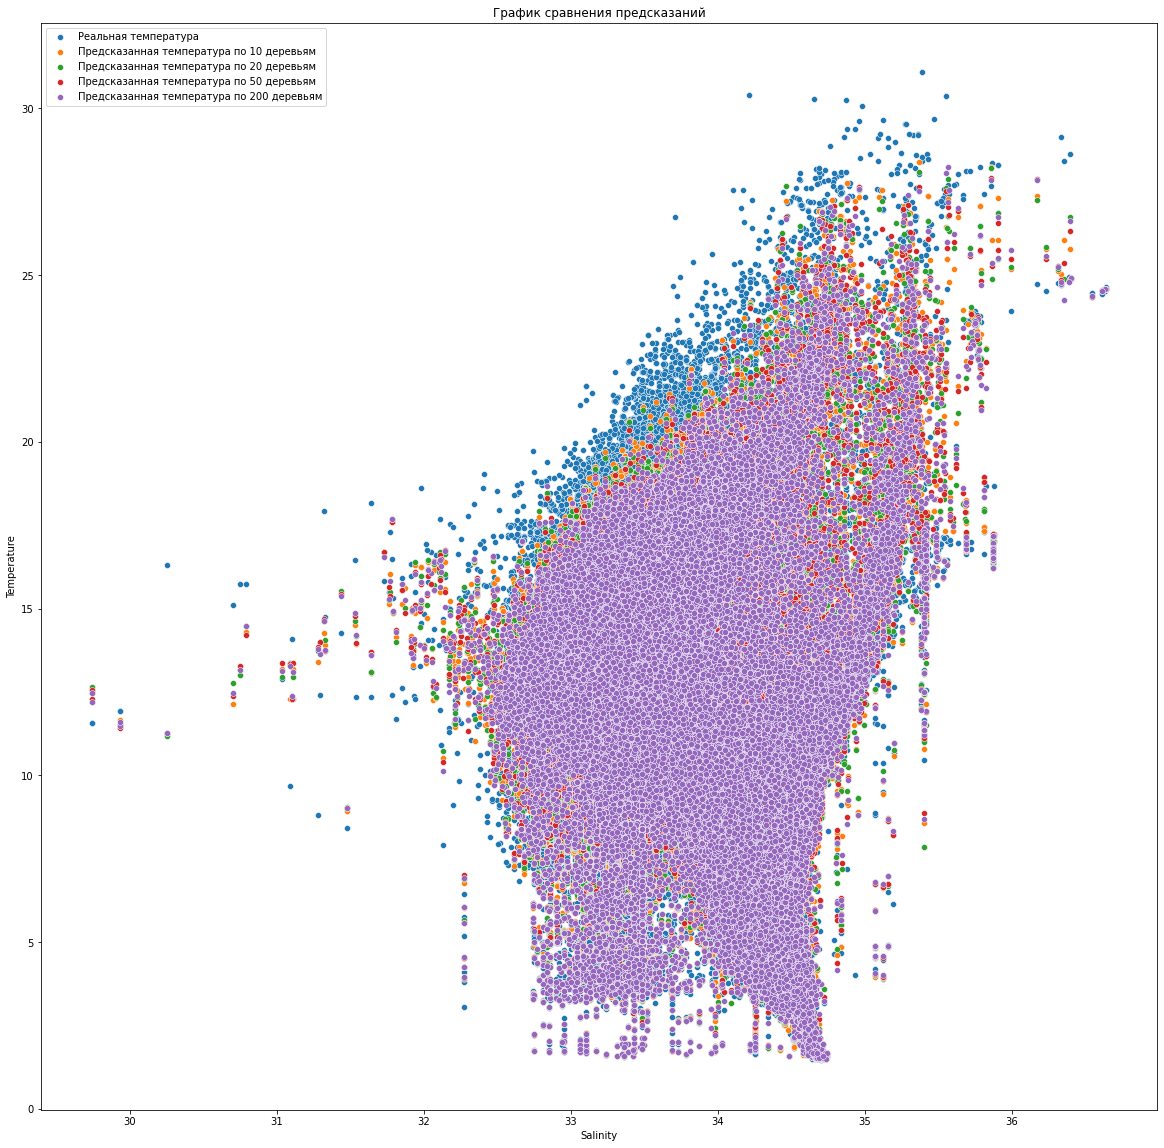

In [176]:
plt.figure(figsize=(20,20))
plt.title("График сравнения предсказаний")
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temperature", label = "Реальная температура")
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temp_pred_forest", label= "Предсказанная температура по 10 деревьям")
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temp_pred_forest_20", label = "Предсказанная температура по 20 деревьям")
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temp_pred_forest_50", label = "Предсказанная температура по 50 деревьям")
sns.scatterplot(data=result_df_forest, x="Salinity", y="Temp_pred_forest_200", label = "Предсказанная температура по 200 деревьям")

#### Вывод: при увеличении количества деревьев модель случайного леса будет более точная.
Самый точный прогноз по случайному лесу был в модели, у которой количество деревьев было равно 200.

## Деревья решений

Обучаем модель деревьев решений по обучающей выборке.

Предсказываем результат (температуру)

In [177]:
%%time
dt_reg = DecisionTreeRegressor()
dt_reg.fit(X_train, y_train)
y_pred_tree = dt_reg.predict(X_test)
y_pred_tree

Wall time: 1.34 s


array([ 6.42071429, 18.7735    , 11.18      , ..., 11.99333333,
       15.683     ,  7.002625  ])

#### Создаем датафрейм, состоящий из:
1) Солености воды - Salinity

2) Глубины воды - Depth

3) Температура воды - Temperature (реальное значение)

4) Температура воды предсказанное - Temp_pred_tree (предсказанное значение)

In [178]:
result_df_tree = pd.DataFrame(X_test, columns=["Salinity", "Depth"])
result_df_tree["Temperature"] = y_test
result_df_tree["Temp_pred_tree"] = y_pred_tree
result_df_tree.head()

,Salinity,Depth,Temperature,Temp_pred_tree
0,34.1580,400.0,6.340,6.420714
1,33.5312,0.0,16.125,18.773500
2,33.7410,87.0,10.460,11.180000
3,33.5700,74.0,13.470,12.241667
4,33.3570,30.0,14.960,14.288571


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

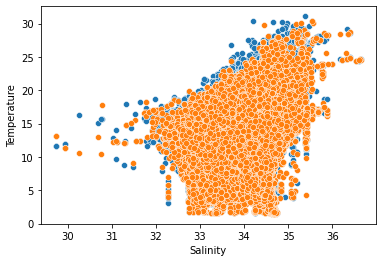

In [179]:
sns.scatterplot(data=result_df_tree, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_tree, x="Salinity", y="Temp_pred_tree")

Выводим оценки для прогнозируемых данных

In [180]:
print("Коэффициент детерминации прогноза дерева решений: %.2f" % dt_reg.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_tree))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_tree))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_tree))

Коэффициент детерминации прогноза дерева решений: 0.88
Средняя Абсолютная ошибка (Mean Absolute Error): 1.2527357558186267
Средняя квадратичная ошибка (Mean Squared Error): 3.953301896642144
Коэффициент детерминации:  0.782007265604557


#### Как видим из графика и оценок, модель дерева решений достаточно хорошая и точная, но, сравним ее с самой точной на данный момент моделью - случайный лес с числом деревьев равным 200:

1) Коэффициент детерминации дерева решений равен 0.7819595906438878, а у случайного леса он будет равен 0.8065295727231004, что показывает точность прогноза более точным у случайного леса.

2) Ошибки прогноза MAE, MSE у дерева решений равны 1.2528763483302578 и 3.954166482853967, а у случайного леса они равны 1.1927620967898527 и 3.508589445510995. У случайного леса ошибки прогноза меньше, соответветсвенно, сделаем вывод, что модель дерева решений достаточно точная, но при сравнении с моделью случайного леса, самой точной и эффективной моделью будет случайный лес. 

## Регрессия LASSO


Обучаем модель Lasso по обучающей выборке. 

Предсказываем результат температуры.

In [181]:
%%time
model_Lasso = LassoCV(max_iter=1_000_000, n_alphas = 1000)
model_Lasso.fit(X_train, y_train)
y_pred_Lasso = model_Lasso.predict(X_test)
y_pred_Lasso

Wall time: 22.5 s


array([ 9.22064909, 12.84233946, 12.0546218 , ..., 12.18138097,
       12.7517972 ,  9.95404139])

#### Создаем датафрейм, состоящий из:
1) Солености воды - Salinity

2) Глубины воды - Depth

3) Температура воды - Temperature (реальное значение)

4) Температура воды предсказанное - Temp_pred_Lasso (предсказанное значение)

In [182]:
result_df_Lasso = pd.DataFrame(X_test, columns=["Salinity", "Depth"])
result_df_Lasso["Temperature"] = y_test
result_df_Lasso["Temp_pred_Lasso"] = y_pred_Lasso
result_df_Lasso.head()

,Salinity,Depth,Temperature,Temp_pred_Lasso
0,34.1580,400.0,6.340,9.220649
1,33.5312,0.0,16.125,12.842339
2,33.7410,87.0,10.460,12.054622
3,33.5700,74.0,13.470,12.172327
4,33.3570,30.0,14.960,12.570713


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

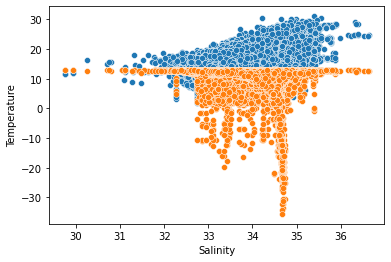

In [183]:
sns.scatterplot(data=result_df_Lasso, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_Lasso, x="Salinity", y="Temp_pred_Lasso")

#### Выводим оценки для прогнозируемых данных

In [184]:
print("Коэффициент детерминации прогноза Lasso: %.2f" % model_Lasso.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_Lasso))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_Lasso))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_Lasso))

Коэффициент детерминации прогноза Lasso: 0.45
Средняя Абсолютная ошибка (Mean Absolute Error): 2.4251077668790186
Средняя квадратичная ошибка (Mean Squared Error): 9.878933883364382
Коэффициент детерминации:  0.45525642451552595


#### Данная модель не эффективна: 

1) Коэффициент детерминации низкий, равен 0.45525642451552595, соответственно, точность верного прогноза достаточно низкая.

2) Ошибки MAE, MSE достаточно высокие, равны 2.4251077668790186 и 9.878933883364382, следовательно, ошибка прогноза у модели высокая, модель является не точной.

## Гребневая регрессия (ридж-регрессия)

Обучаем ридж-регрессию на обучающем наборе данных (выборке).

Предсказываем результат температуры.

In [185]:
%%time
model_Ridge = RidgeCV()
model_Ridge.fit(X_train, y_train)
y_pred_Ridge = model_Ridge.predict(X_test)
y_pred_Ridge

Wall time: 149 ms


array([[ 8.9674758 ],
       [13.02050486],
       [12.04164306],
       ...,
       [12.68564742],
       [13.07625035],
       [ 9.73664708]])

#### Создаем датафрейм, состоящий из:
1) Солености воды - Salinity

2) Глубины воды - Depth

3) Температура воды - Temperature (реальное значение)

4) Температура воды предсказанное - Temp_pred_Ridge (предсказанное значение)

In [186]:
result_df_Ridge = pd.DataFrame(X_test, columns=["Salinity", "Depth"])
result_df_Ridge["Temperature"] = y_test
result_df_Ridge["Temp_pred_Ridge"] = y_pred_Ridge
result_df_Ridge.head()

,Salinity,Depth,Temperature,Temp_pred_Ridge
0,34.1580,400.0,6.340,8.967476
1,33.5312,0.0,16.125,13.020505
2,33.7410,87.0,10.460,12.041643
3,33.5700,74.0,13.470,12.372907
4,33.3570,30.0,14.960,13.009567


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

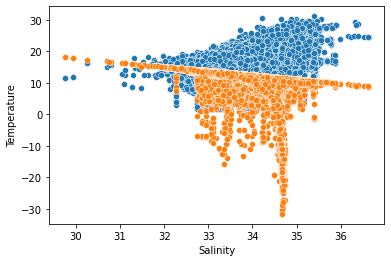

In [187]:
sns.scatterplot(data=result_df_Ridge, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_Ridge, x="Salinity", y="Temp_pred_Ridge")

#### Выводим оценки для прогнозируемых данных

In [193]:
print("Коэффициент детерминации прогноза Ridge: %.2f" % model_Ridge.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_Ridge))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_Ridge))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_Ridge))

Коэффициент детерминации прогноза Ridge: 0.47
Средняя Абсолютная ошибка (Mean Absolute Error): 2.331995238650464
Средняя квадратичная ошибка (Mean Squared Error): 9.607665087825655
Коэффициент детерминации:  0.47021471205381726


#### Данная модель не эффективна:

1) Коэффициент детерминации низкий, равен 0.47021471205381726, соответственно, точность верного прогноза достаточно низкая, модель плохая и не точная.

2) Ошибки MAE, MSE достаточно высокие, равны 2.331995238650464 и 9.607665087825655, следовательно, ошибка прогноза у модели высокая, модель является не точной.

## Метод k ближайших соседей


Обучаем метод k ближайших соседей на обучающем наборе данных. Обучение модели будет в начале на количестве соседей равных двум.

Предсказываем результат

In [194]:
%%time
model_neigh = KNeighborsRegressor(n_neighbors=2)
model_neigh.fit(X_train, y_train)
y_pred_neigh = model_neigh.predict(X_test)
y_pred_neigh

Wall time: 11.5 s


array([[ 6.655 ],
       [18.7735],
       [11.41  ],
       ...,
       [13.42  ],
       [17.831 ],
       [ 7.0655]])

#### Создаем датафрейм, состоящий из:
1) Солености воды - Salinity

2) Глубины воды - Depth

3) Температура воды - Temperature (реальное значение)

4) Температура воды предсказанное - Temp_pred_neigh (предсказанное значение)

In [195]:
result_df_neigh = pd.DataFrame(X_test, columns=["Salinity", "Depth"])
result_df_neigh["Temperature"] = y_test
result_df_neigh["Temp_pred_neigh"] = y_pred_neigh
result_df_neigh.head()

,Salinity,Depth,Temperature,Temp_pred_neigh
0,34.1580,400.0,6.340,6.6550
1,33.5312,0.0,16.125,18.7735
2,33.7410,87.0,10.460,11.4100
3,33.5700,74.0,13.470,11.2100
4,33.3570,30.0,14.960,12.8200


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

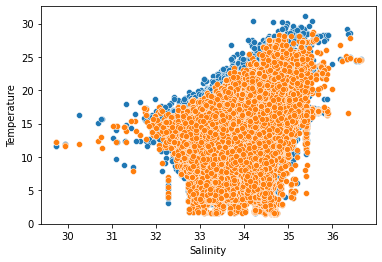

In [196]:
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temp_pred_neigh")

Выводим оценки для прогнозируемых данных

In [197]:
print("Коэффициент детерминации прогноза KNeighborsRegressor: %.2f" % model_neigh.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_neigh))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_neigh))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_neigh))

Коэффициент детерминации прогноза KNeighborsRegressor: 0.81
Средняя Абсолютная ошибка (Mean Absolute Error): 1.364178394894001
Средняя квадратичная ошибка (Mean Squared Error): 4.6223689108979436
Коэффициент детерминации:  0.7451136127177638


Как мы можем заметить, коэффициент детерминации у данной модели достаточно высокий, а время обучения составляет чуть более 10 секунд. Так же, ошибки прогноза MAE, MSE не особо высокие.

Попробуем обучить данную модель на разных количествах соседей, посмотрим на результаты.

### Метод k ближайших соседей по 3 соседям

In [202]:
%%time
model_neigh = KNeighborsRegressor(n_neighbors=3)
model_neigh.fit(X_train, y_train)
y_pred_neigh3 = model_neigh.predict(X_test)
y_pred_neigh3

Wall time: 11.1 s


array([[ 6.78666667],
       [18.47      ],
       [11.        ],
       ...,
       [13.00666667],
       [18.354     ],
       [ 7.13366667]])

Запишем в датафрейм результат прогноза, а так же, построим графики.

In [205]:
result_df_neigh["Temp_pred_neigh3"] = y_pred_neigh3
result_df_neigh.head()

,Salinity,Depth,Temperature,Temp_pred_neigh,Temp_pred_neigh3
0,34.1580,400.0,6.340,6.6550,6.786667
1,33.5312,0.0,16.125,18.7735,18.470000
2,33.7410,87.0,10.460,11.4100,11.000000
3,33.5700,74.0,13.470,11.2100,11.100000
4,33.3570,30.0,14.960,12.8200,13.180000


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

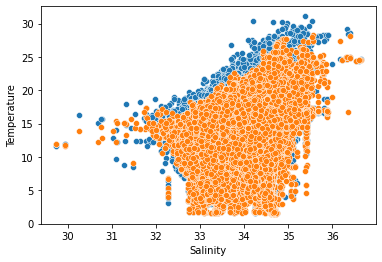

In [206]:
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temp_pred_neigh3")

Выводим оценки для прогнозируемых данных

In [207]:
print("Коэффициент детерминации прогноза neigh: %.2f" % model_neigh.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_neigh3))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_neigh3))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_neigh3))

Коэффициент детерминации прогноза neigh: 0.83
Средняя Абсолютная ошибка (Mean Absolute Error): 1.2946335921405847
Средняя квадратичная ошибка (Mean Squared Error): 4.135770975872921
Коэффициент детерминации:  0.7719455666591966


Как мы видим, при увеличении кол-ва соседей до 3, коэффициент детерминации увеличился, ошибки прогноза MAE, MSE снизились, так же, время обучение низкое, всего 11 секунд.
Попробуем теперь увеличить количество соседей до 5. 

### Метод k ближайших соседей по 5 соседям

In [211]:
%%time
model_neigh = KNeighborsRegressor(n_neighbors=5)
model_neigh.fit(X_train, y_train)
y_pred_neigh5 = model_neigh.predict(X_test)
y_pred_neigh5

Wall time: 11.1 s


array([[ 6.552 ],
       [18.632 ],
       [10.9   ],
       ...,
       [12.2   ],
       [17.7844],
       [ 6.9142]])

Запишем в датафрейм результат прогноза, а так же, построим графики.

In [212]:
result_df_neigh["Temp_pred_neigh5"] = y_pred_neigh5
result_df_neigh.head()

,Salinity,Depth,Temperature,Temp_pred_neigh,Temp_pred_neigh3,Temp_pred_neigh5
0,34.1580,400.0,6.340,6.6550,6.786667,6.552
1,33.5312,0.0,16.125,18.7735,18.470000,18.632
2,33.7410,87.0,10.460,11.4100,11.000000,10.900
3,33.5700,74.0,13.470,11.2100,11.100000,11.010
4,33.3570,30.0,14.960,12.8200,13.180000,13.704


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

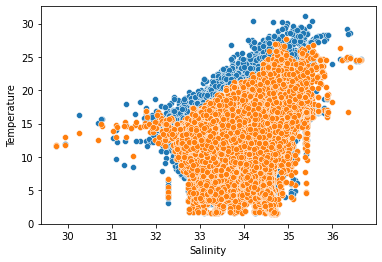

In [213]:
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temp_pred_neigh5")

Выводим оценки для прогнозируемых данных

In [214]:
print("Коэффициент детерминации прогноза neigh: %.2f" % model_neigh.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_neigh5))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_neigh5))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_neigh5))

Коэффициент детерминации прогноза neigh: 0.83
Средняя Абсолютная ошибка (Mean Absolute Error): 1.2356480363987443
Средняя квадратичная ошибка (Mean Squared Error): 3.7602032539443724
Коэффициент детерминации:  0.7926550992965626


После увеличения количества соседей до 5, коэффициент детерминации немного увеличился, ошибки прогноза достаточно сильно упали, время обучения низкое, всего 11 секунд. 

## Метод k ближайших соседей по 7 соседям

In [215]:
%%time
model_neigh = KNeighborsRegressor(n_neighbors=7)
model_neigh.fit(X_train, y_train)
y_pred_neigh7 = model_neigh.predict(X_test)
y_pred_neigh7

Wall time: 11.4 s


array([[ 6.60142857],
       [17.85571429],
       [10.84428571],
       ...,
       [12.04714286],
       [18.10742857],
       [ 7.03014286]])

Запишем в датафрейм результат прогноза, а так же, построим графики.

In [216]:
result_df_neigh["Temp_pred_neigh7"] = y_pred_neigh7
result_df_neigh.head()

,Salinity,Depth,Temperature,Temp_pred_neigh,Temp_pred_neigh3,Temp_pred_neigh5,Temp_pred_neigh7
0,34.1580,400.0,6.340,6.6550,6.786667,6.552,6.601429
1,33.5312,0.0,16.125,18.7735,18.470000,18.632,17.855714
2,33.7410,87.0,10.460,11.4100,11.000000,10.900,10.844286
3,33.5700,74.0,13.470,11.2100,11.100000,11.010,11.181429
4,33.3570,30.0,14.960,12.8200,13.180000,13.704,13.935714


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

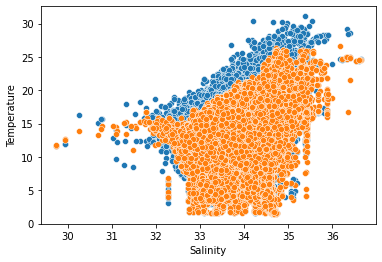

In [217]:
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temp_pred_neigh7")

Выводим оценки для прогнозируемых данных

In [219]:
print("Коэффициент детерминации прогноза neigh: %.2f" % model_neigh.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_neigh7))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_neigh7))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_neigh7))

Коэффициент детерминации прогноза neigh: 0.83
Средняя Абсолютная ошибка (Mean Absolute Error): 1.211945339941576
Средняя квадратичная ошибка (Mean Squared Error): 3.6029223607012164
Коэффициент детерминации:  0.8013278728116223


Коэффициент детерминации немного увеличился, время обучения все так-же составляет 11 секунд, а ошибки прогноза уменьшились.

## Метод k ближайших соседей по 10 соседям

In [220]:
%%time
model_neigh = KNeighborsRegressor(n_neighbors=10)
model_neigh.fit(X_train, y_train)
y_pred_neigh10 = model_neigh.predict(X_test)
y_pred_neigh10

Wall time: 11.1 s


array([[ 6.537 ],
       [17.289 ],
       [10.735 ],
       ...,
       [12.37  ],
       [17.9802],
       [ 7.0458]])

Запишем в датафрейм результат прогноза, а так же, построим графики.

In [222]:
result_df_neigh["Temp_pred_neigh10"] = y_pred_neigh10
result_df_neigh.head()

,Salinity,Depth,Temperature,Temp_pred_neigh,Temp_pred_neigh3,Temp_pred_neigh5,Temp_pred_neigh7,Temp_pred_neigh10
0,34.1580,400.0,6.340,6.6550,6.786667,6.552,6.601429,6.537
1,33.5312,0.0,16.125,18.7735,18.470000,18.632,17.855714,17.289
2,33.7410,87.0,10.460,11.4100,11.000000,10.900,10.844286,10.735
3,33.5700,74.0,13.470,11.2100,11.100000,11.010,11.181429,11.582
4,33.3570,30.0,14.960,12.8200,13.180000,13.704,13.935714,13.805


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

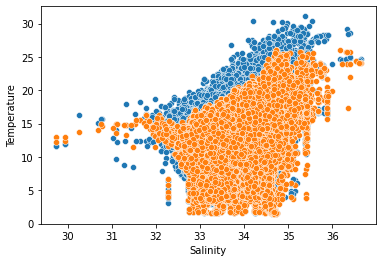

In [223]:
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_neigh, x="Salinity", y="Temp_pred_neigh10")

Выводим оценки для прогнозируемых данных

In [224]:
print("Коэффициент детерминации прогноза neigh: %.2f" % model_neigh.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_neigh10))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_neigh10))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_neigh10))

Коэффициент детерминации прогноза neigh: 0.83
Средняя Абсолютная ошибка (Mean Absolute Error): 1.1915752152069976
Средняя квадратичная ошибка (Mean Squared Error): 3.485437910412319
Коэффициент детерминации:  0.8078061932731018


Вывод по данной модели: С увеличением количества соседей, коэффициент детерминации увеличивается, ошибки прогноза уменьшаются. Данная модель достаточно эффективна. 

#### Попробуем найти по результатам метрик самую точную модель.

1) Коэффициент детерминации: у k ближ. соседей самая низкая, равна 0.8078

2) Средняя квадратичная ошибка: у k ближ. соседей самая низкая, равна 3.4854

3) Средняя абсолютная ошибка: у k ближ. соседей самая низкая, равна 1.1915

#### По результатам всех метрик, результаты метода k ближайших соседей самый лучшие. Соответсвенно, самой точной и эффективной моделью можно назвать модель метода k ближайших соседей.

Второй по точности и эффективности является модель случайного леса. Ошибки прогноза данной модели низкие, а коэффициент детерминации высокий, что свидетельствует о том, что модель случайного леса является тоже достаточно перспективной моделью для решения задачи зависимости температуры воды от солености воды.

## Grid Search


Используем GridSearch для поиска самых эффективных гиперпараметров у лучших по точности моделей.
Нам необходимо подобрать самые эффективные гиперпараметры, для того, чтобы улучшить точности этих моделей.

Так как при увеличении кол-ва деревьев растет время обучения, а точность не сильно вырастает, то попробуем использовать grid search, чтобы найти оптимальные параметры модели, таким образом, найдя оптимальные параметры, мы сможем определить компромисс между желаемой точностью и временем обучения.

In [80]:
param_grid = [
{
    'max_depth': [80, 90, 100, 110],
    'n_estimators': [3, 10, 50, 100]
}
]
rangom_forest = RandomForestRegressor()
grid_search = GridSearchCV(rangom_forest, param_grid, cv=5,
                          scoring='neg_mean_squared_error')

Обучение GridSearch по сетке параметров max_depth, n_estimators

In [81]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [80, 90, 100, 110],
                          'n_estimators': [3, 10, 50, 100]}],
             scoring='neg_mean_squared_error')

После обучения модели, выберем лучшие параметры.

In [92]:
grid_search.best_params_

{'max_depth': 90, 'n_estimators': 100}

In [93]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=90)

Обучаем модель случайного леса по найденным параметрам.

In [226]:
%%time
rangom_forest_total = RandomForestRegressor(max_depth=90, n_estimators= 100)
rangom_forest_total.fit(X_train, y_train)

Wall time: 1min 32s


RandomForestRegressor(max_depth=90)

Делаем предсказание результата.

In [227]:
y_pred_rangom = rangom_forest_total.predict(X_test)

#### Создаем датафрейм, состоящий из:
1) Солености воды - Salinity

2) Глубины воды - Depth

3) Температура воды - Temperature (реальное значение)

4) Температура воды предсказанное - Temp_pred_neigh (предсказанное значение)

In [228]:
result_df_rangom = pd.DataFrame(X_test, columns=["Salinity", "Depth"])
result_df_rangom["Temperature"] = y_test
result_df_rangom["Temp_pred_rangom"] = y_pred_rangom
result_df_rangom.head()

,Salinity,Depth,Temperature,Temp_pred_rangom
0,34.1580,400.0,6.340,6.423366
1,33.5312,0.0,16.125,18.394651
2,33.7410,87.0,10.460,11.079215
3,33.5700,74.0,13.470,12.231536
4,33.3570,30.0,14.960,14.248474


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

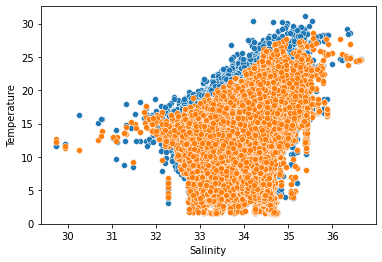

In [229]:
sns.scatterplot(data=result_df_rangom, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_rangom, x="Salinity", y="Temp_pred_rangom")

Выводим оценки для прогнозируемых данных

In [243]:
print("Коэффициент детерминации прогноза RandomForestRegressor: %.2f" % rangom_forest_total.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_rangom))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_rangom))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_rangom))

Коэффициент детерминации прогноза RandomForestRegressor: 0.87
Средняя Абсолютная ошибка (Mean Absolute Error): 1.1933623642082611
Средняя квадратичная ошибка (Mean Squared Error): 3.5143155290733468
Коэффициент детерминации:  0.8062138253691749


Поиск по сетке особо не дал никаких улучшений, попробуем ввести другие гиперпараметры.

In [232]:
param_grid = [
{
    "max_depth" : [2,3,4,6,7],
    "n_estimators" : [5, 10, 20, 40],
}
]
random_forest = RandomForestRegressor()
grid_search = GridSearchCV(random_forest, param_grid, cv=5,
                          scoring='neg_mean_squared_error')

Обучение GridSearch

In [233]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [2, 3, 4, 6, 7],
                          'n_estimators': [5, 10, 20, 40]}],
             scoring='neg_mean_squared_error')

Поиск по сетке выделил гиперпараметры max_depth = 7, n_estimators = 20, лучшими.

In [234]:
grid_search.best_params_

{'max_depth': 7, 'n_estimators': 20}

In [235]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=7, n_estimators=20)

Создадим модель, введем туда полученные гиперпараметры, а так же, обучим.

Сделаем предсказание результата.

In [236]:
%%time
random_forest_total = RandomForestRegressor(max_depth=7, n_estimators=20)
random_forest_total.fit(X_train, y_train)
y_pred_random2 = random_forest_total.predict(X_test)
y_pred_random2

Wall time: 8.74 s


array([ 6.37723939, 15.69679022, 11.72559742, ..., 12.47670091,
       15.69679022,  7.29299873])

Запишем результат предсказанной температуры в датафрейм

In [245]:
result_df_rangom["Temp_pred_random2"] = y_pred_random2
result_df_rangom.head()

,Salinity,Depth,Temperature,Temp_pred_rangom,Temp_pred_random2
0,34.1580,400.0,6.340,6.423366,6.377239
1,33.5312,0.0,16.125,18.394651,15.696790
2,33.7410,87.0,10.460,11.079215,11.725597
3,33.5700,74.0,13.470,12.231536,11.886309
4,33.3570,30.0,14.960,14.248474,14.769869


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

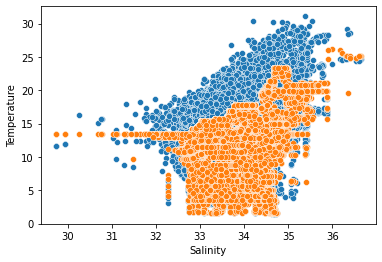

In [238]:
sns.scatterplot(data=result_df_rangom, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_rangom, x="Salinity", y="Temp_pred_random2")

Выведем оценки для прогнозируемых данных

In [242]:
print("Коэффициент детерминации прогноза RandomForestRegressor: %.2f" % random_forest_total.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_random2))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_random2))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_random2))

Коэффициент детерминации прогноза RandomForestRegressor: 0.81
Средняя Абсолютная ошибка (Mean Absolute Error): 1.185505933608214
Средняя квадратичная ошибка (Mean Squared Error): 3.356044712663615
Коэффициент детерминации:  0.8149411851676921


#### Поиск по сетке значительно улучшил модель случайного леса, коэффициент детерминации стал выше, ошибки снизились.
    Коэффициент детерминации до поиска по сетке был равен  0.8065, а после стал равен 0.8149
    Средняя Абсолютная ошибка снизилась, была равна 1.19276, а после стала равна 1.1855
    Средняя квадратичная ошибка снизилась, была равна 3.50858, а после стала равна 3.356
    Время обучения модели значительно снизилось, было более 4 минут, стало почти что 9 секунд, что является существенным улучшением.
#### Исходя из всего вышеперечисленного, нам удалось с помощью поиска по сетке значительно улучшить модель, а так же, снизить время обучения почти на 4 минуты.

#### Оптимальные гиперпараметры для модели случайного леса: 
1) max_depth=7

2) n_estimators=20

### Grid Search для метода k ближайших соседей

Создаем словарь, содержащий все гиперпараметры, которые нужно проверить.

Создаем модель k ближайших соседей, и модель поиска по сетке.

In [275]:
param_gridK = [
{
    'n_neighbors': [3, 5, 10, 20, 40, 50, 60, 100, 120, 160], 
    'weights': ['uniform','distance'],
    'p' : [1, 2, 5]
}
]
neigh_model = KNeighborsRegressor()
grid_search_kn = GridSearchCV(neigh_model, param_gridK, cv=5,
                          scoring='neg_mean_squared_error')

Обучаем GridSearchCV (Поиск по сетке) на обучающих выборках

In [276]:
grid_search_kn.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': [3, 5, 10, 20, 40, 50, 60, 100, 120,
                                          160],
                          'p': [1, 2, 5], 'weights': ['uniform', 'distance']}],
             scoring='neg_mean_squared_error')

В результате поиска получаем самые оптимальные гиперпараметры.

In [277]:
grid_search_kn.best_params_

{'n_neighbors': 40, 'p': 5, 'weights': 'uniform'}

In [278]:
grid_search_kn.best_estimator_

KNeighborsRegressor(n_neighbors=40, p=5)

Создаем модель K ближайших соседей с найденными гиперпараметрами.

Обучаем модель по обучающей выборке.

Предсказываем результат.

In [288]:
%%time
model_neigh_total = KNeighborsRegressor(n_neighbors=40, p=5)
model_neigh_total.fit(X_train, y_train)
y_pred_neigh_grid = model_neigh_total.predict(X_test)
y_pred_neigh_grid

Wall time: 15.2 s


array([[ 6.47225 ],
       [16.525075],
       [11.25245 ],
       ...,
       [12.95575 ],
       [16.2731  ],
       [ 7.146975]])

#### Создаем датафрейм, состоящий из:
1) Солености воды - Salinity

2) Глубины воды - Depth

3) Температура воды - Temperature (реальное значение)

4) Температура воды предсказанное - Temp_pred_neigh (предсказанное значение)

In [289]:
result_df_neigh_with_grid = pd.DataFrame(X_test, columns=["Salinity", "Depth"])
result_df_neigh_with_grid["Temperature"] = y_test
result_df_neigh_with_grid["Temp_pred_neigh"] = y_pred_neigh_grid
result_df_neigh_with_grid.head()

,Salinity,Depth,Temperature,Temp_pred_neigh
0,34.1580,400.0,6.340,6.472250
1,33.5312,0.0,16.125,16.525075
2,33.7410,87.0,10.460,11.252450
3,33.5700,74.0,13.470,12.395250
4,33.3570,30.0,14.960,14.973250


#### График сравнения предсказанной температуры воды от реальной температуры воды.
1) Предсказанная температура воды отмечена оранжевым цветом.

2) Реальная температура воды - синим.

<AxesSubplot:xlabel='Salinity', ylabel='Temperature'>

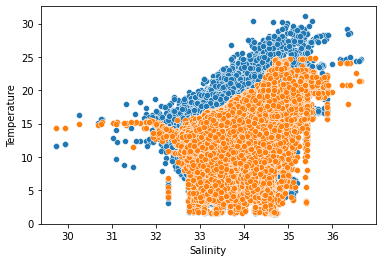

In [290]:
sns.scatterplot(data=result_df_neigh_with_grid, x="Salinity", y="Temperature")
sns.scatterplot(data=result_df_neigh_with_grid, x="Salinity", y="Temp_pred_neigh")

Выводим оценки для прогнозируемых данных

In [299]:
print("Коэффициент детерминации прогноза KNeighborsRegressor: %.2f" % model_neigh_total.score(X_train, y_train))

print("Средняя Абсолютная ошибка (Mean Absolute Error):", metrics.mean_absolute_error(y_test, y_pred_neigh_grid))
print("Средняя квадратичная ошибка (Mean Squared Error):", metrics.mean_squared_error(y_test, y_pred_neigh_grid))
print("Коэффициент детерминации: ", metrics.r2_score(y_test, y_pred_neigh_grid))

Коэффициент детерминации прогноза KNeighborsRegressor: 0.82
Средняя Абсолютная ошибка (Mean Absolute Error): 1.168892629630058
Средняя квадратичная ошибка (Mean Squared Error): 3.348122217057637
Коэффициент детерминации:  0.8153780469418586


#### Поиск по сетке улучшил модель k ближайших соседей, так как коэффициент детерминации увеличился, ошибки MAE, MSE снизились. Данная модель является самой эффективной.

Сравнение результатов метрик метода k ближайших соседей до GridSearchCv и после:

1) Коэффициент детерминации был 0.80780, стал 0.81537

2) Средняя квадратичная ошибка (Mean Squared Error) была 3.48543, стала 3.34812

3) Средняя Абсолютная ошибка (Mean Absolute Error) была 1.19157, стала 1.16889

Время обучения модели с гиперпараметрами, найденными после выполнения GridSearchCV, стало немного медленнее (на 4 секунды дольше), что является не существенным.

#### В итоге, метод k ближайших соседей является самой точной и эффективной моделью, так как точность верного прогноза самое высокое по всем моделям, ошибки прогноза самые низкие.
